In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
EP6 = pd.read_csv("/content/drive/MyDrive/ Thesis 2023/EP6_total3.csv")

In [3]:
import numpy as np

In [4]:
import pickle

## 6th EP
Best Manuel Medina: 1337
Worst Patrick Louis: 28217

In [ ]:
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/lsa_comps6th.pickle', 'rb') as f:
    lsa_comps6 = pickle.load(f)

In [ ]:
EP6["raw_text"].isna().sum() #quitar las instancias que no tienen texto


409

In [ ]:
EP6 = EP6.drop(["Unnamed: 0"],axis=1)


In [ ]:
print(EP6["Type of Vote"].isna().sum())
print(EP6["Policy_area"].isna().sum())
print(EP6["Title"].isna().sum())

5
0
0


In [ ]:
EP6  = EP6.dropna(subset=['raw_text'])
# Fill NaN values with empty strings
EP6.fillna('', inplace=True)


In [ ]:
lsa_comps6 = lsa_comps6.astype(np.int64)

In [ ]:
EP6["raw_text"].isna().sum() #quitar las instancias que no tienen texto


0

In [ ]:
print(EP6["Type of Vote"].isna().sum())
print(EP6["Policy_area"].isna().sum())
print(EP6["Title"].isna().sum())

0
0
0


In [ ]:
EP6  = EP6.dropna(subset=['raw_text'])
# Fill NaN values with empty strings
EP6.fillna('', inplace=True)


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 6.0 MB/s eta 0:00:00


# Model best EP6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []
accuracy_results_original = {}
# Loop through each MEP column and train a separate model for each MEP

    # Step 1: Prepare the data
X = lsa_comps6  # Input features (TF-IDF + truncated SVD features)
y = EP6["1337"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])

for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)


The least populated class in y has only 3 members, which is less than n_splits=4.


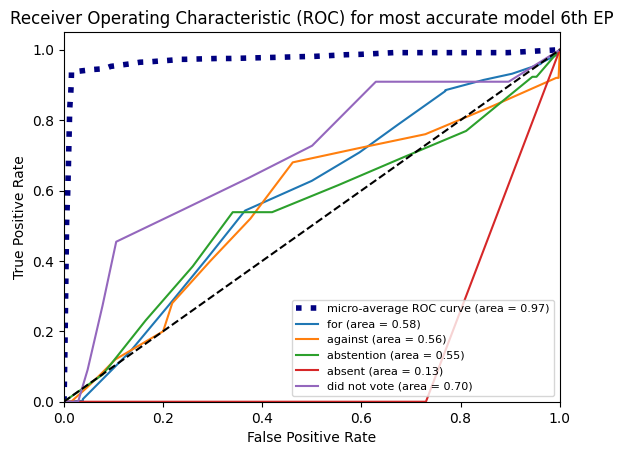

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for most accurate model 6th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [ ]:
dummy = []
for i in range(0,20):
    dummy.append(str(i))


In [ ]:
dummy[0]="Industry,research & energy/Transport & tourism/Budget"
dummy[1]="Development/Gender equality/International trade"
dummy[2]="Constitutional& inter-institutional affairs/Employment & social affairs"
dummy[3]="Civil liberties,justice & home affairs/Budget/Foreign & security policy"
dummy[8]= "International trade/Juridical affairs/economics"

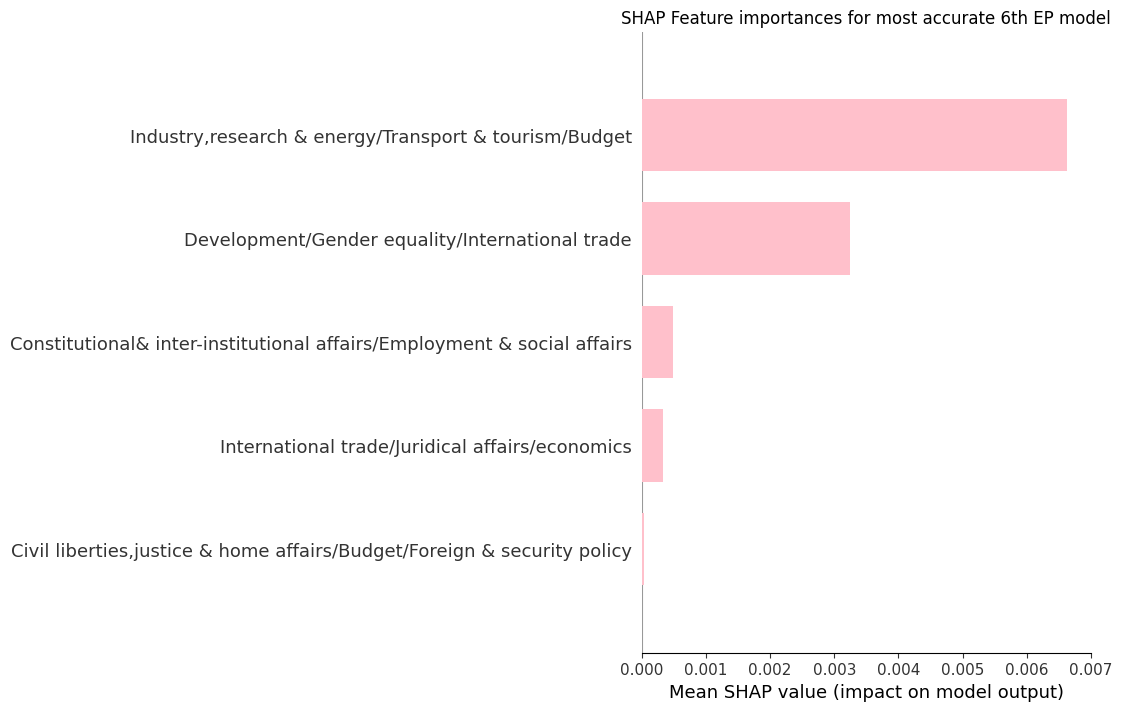

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=5,plot_type="bar", color="pink",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for most accurate 6th EP model")
plt.xlim([0,0.007])
plt.gcf().set_size_inches(26,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()


# Model worst EP6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []
accuracy_results_original = {}
# Loop through each MEP column and train a separate model for each MEP

    # Step 1: Prepare the data
X = lsa_comps6  # Input features (TF-IDF + truncated SVD features)
y = EP6["28217"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])

for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)


In [ ]:
np.unique(true_labels_array)

array([1, 2, 3, 4, 5])

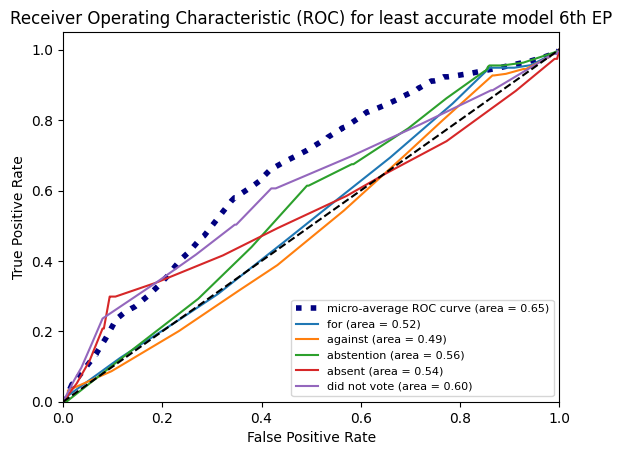

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for least accurate model 6th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

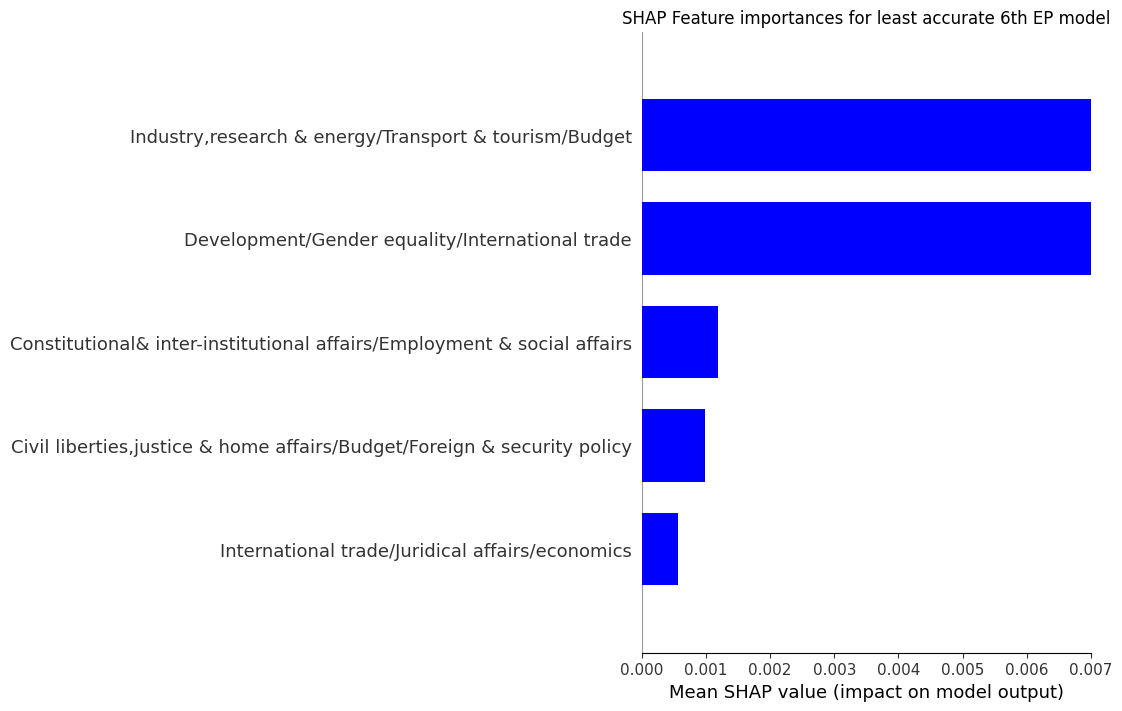

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=5,plot_type="bar", color="blue",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for least accurate 6th EP model")
plt.xlim([0,0.007])
plt.gcf().set_size_inches(26,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()


## EP7

In [ ]:
import pandas as pd
EP7 = pd.read_csv("/content/drive/MyDrive/ Thesis 2023/EP7_total3.csv")

In [ ]:
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/lsa_comps7th.pickle', 'rb') as f:
    lsa_comps7 = pickle.load(f)

In [ ]:
EP7["raw_text"].isna().sum() #quitar las instancias que no tienen texto


0

In [ ]:
EP7 = EP7.drop(["Unnamed: 0"],axis=1)

In [ ]:
EP7["raw_text"].isna().sum() #quitar las instancias que no tienen texto


0

In [ ]:
# Fill NaN values with empty strings
EP7.fillna('', inplace=True)


In [ ]:
lsa_comps7 = lsa_comps7.astype(np.int64)

# EP7 best:
>527

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []

# Loop through each MEP column and train a separate model for each MEP
    # Step 1: Prepare the data
X = lsa_comps7  # Input features (TF-IDF + truncated SVD features)
y = EP7["527"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])
accuracy_score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)
print(np.mean(accuracy_score))


0.9440454124189064


In [ ]:
np.unique(true_labels_array)

array([1, 2, 3, 5])

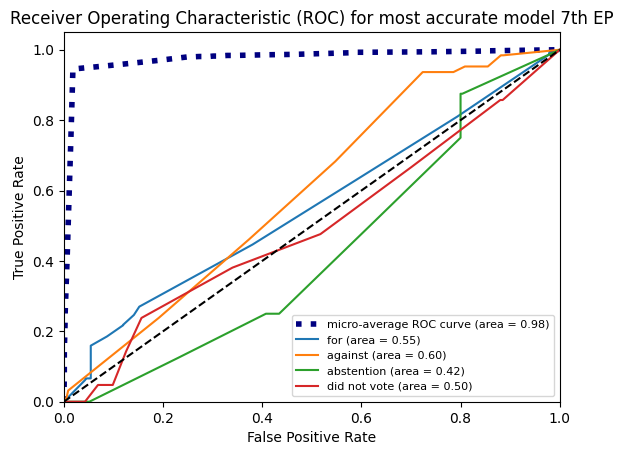

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for most accurate model 7th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [ ]:
dummy = []
for i in range(0,20):
    dummy.append(str(i))


In [ ]:
dummy[0]="Legal/ Constitutional & inter-institutional/Juridical/Legal affairs"
dummy[1]="Budget"
dummy[2]="Budgetary Control"
dummy[4]="Constitutional & inter-institutional/Juridical/employment & social affairs"
dummy[5]="Forein & security policy"
dummy[8]= "International Trade"

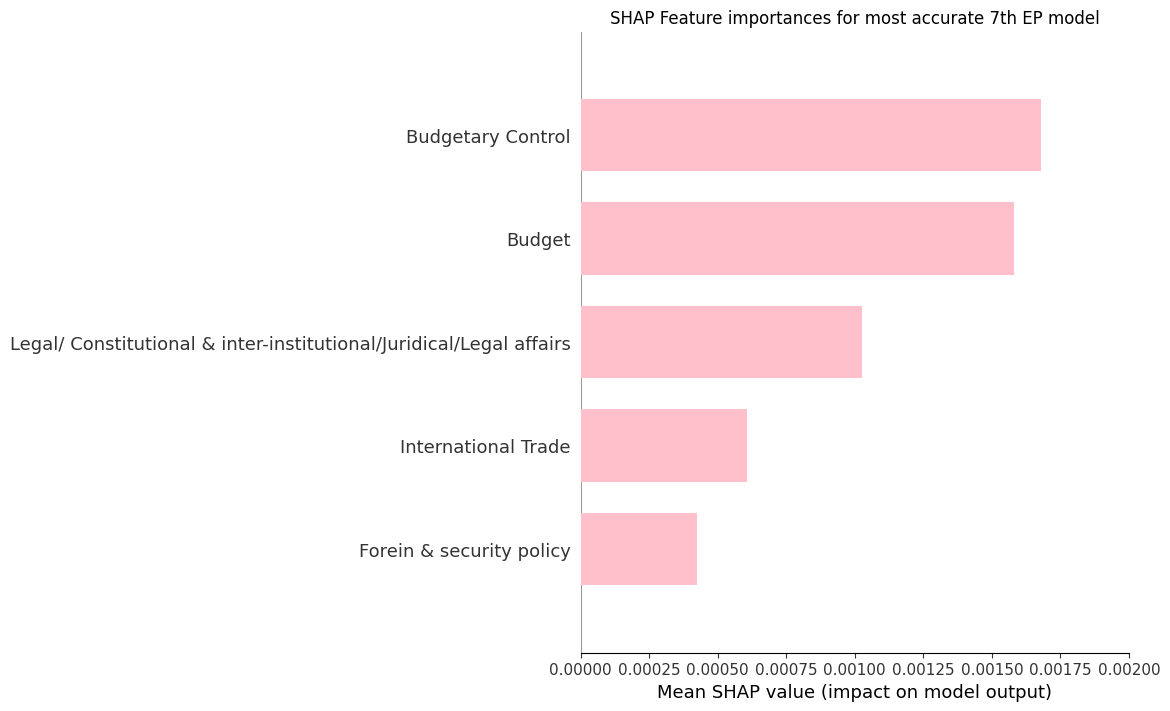

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=5,plot_type="bar", color="pink",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for most accurate 7th EP model")
plt.xlim([0,0.0020])
plt.gcf().set_size_inches(22,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()


# EP7 worst:
>685

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []

# Loop through each MEP column and train a separate model for each MEP
    # Step 1: Prepare the data
X = lsa_comps7  # Input features (TF-IDF + truncated SVD features)
y = EP7["685"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])
accuracy_score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)
print(np.mean(accuracy_score))


0.38747972659870245


In [ ]:
np.unique(true_labels_array)

array([1, 2, 3, 4, 5])

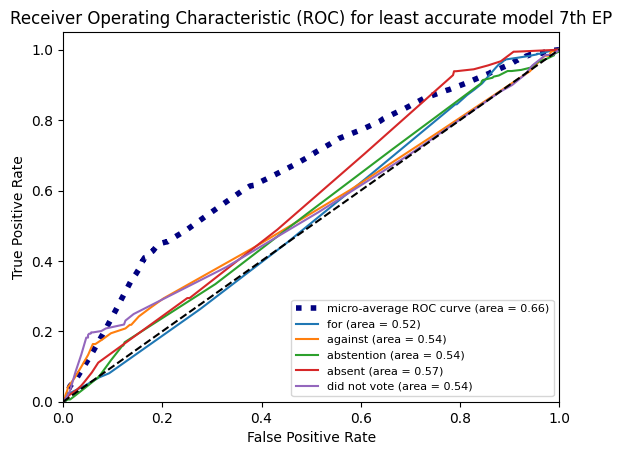

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention", "absent","did not vote"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for least accurate model 7th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

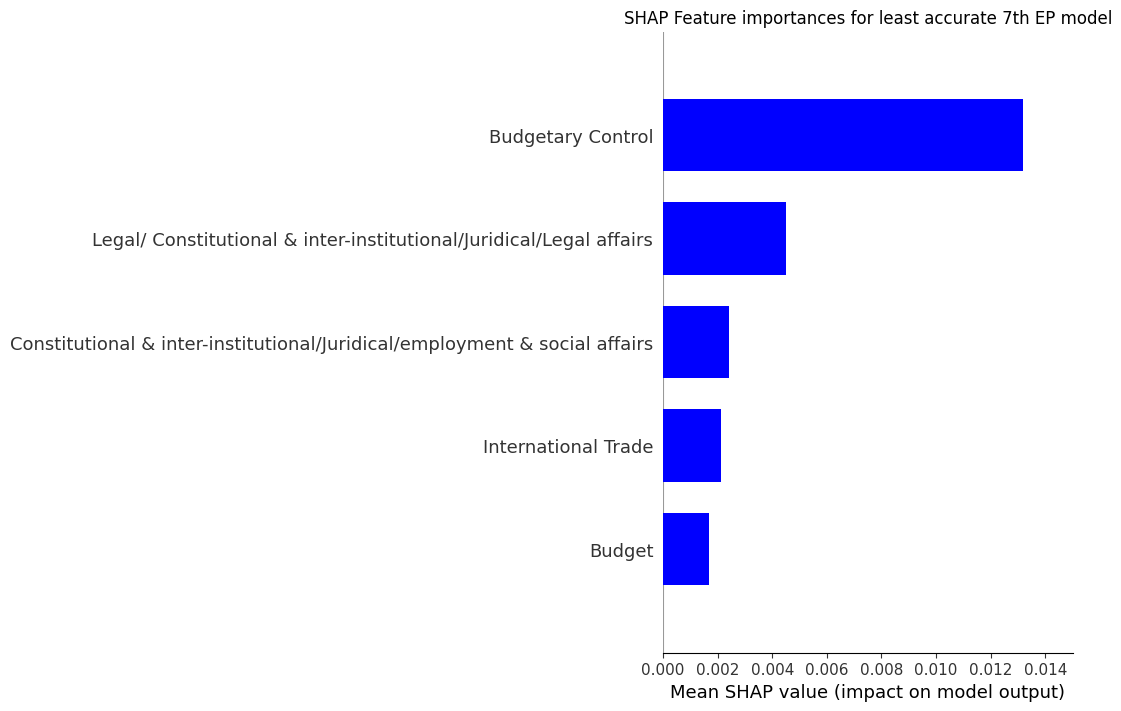

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=5,plot_type="bar", color="blue",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for least accurate 7th EP model")
plt.xlim([0,0.015])
plt.gcf().set_size_inches(28,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()

## EP8

In [5]:
import pandas as pd
EP8 = pd.read_csv("/content/drive/MyDrive/ Thesis 2023/EP8_total3.csv")

In [6]:
with open('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/lsa_comps8th.pickle', 'rb') as f:
    lsa_comps8 = pickle.load(f)

In [7]:
EP8 = EP8.rename(columns = {"De/Policy area":"Policy_area"})

In [8]:
# Fill NaN values with empty strings
EP8.fillna('', inplace=True)


In [9]:
EP8 = EP8.drop(["Unnamed: 0"],axis=1)

In [10]:
lsa_comps8 = lsa_comps8.astype(np.int64)

# EP8 best:
>124851

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []

# Loop through each MEP column and train a separate model for each MEP
    # Step 1: Prepare the data
X = lsa_comps8  # Input features (TF-IDF + truncated SVD features)
y = EP8["124851"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])
accuracy_score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)
print(np.mean(accuracy_score))


0.920251039931891


In [ ]:
np.unique(true_labels_array)

array([1, 2, 3, 4, 5])

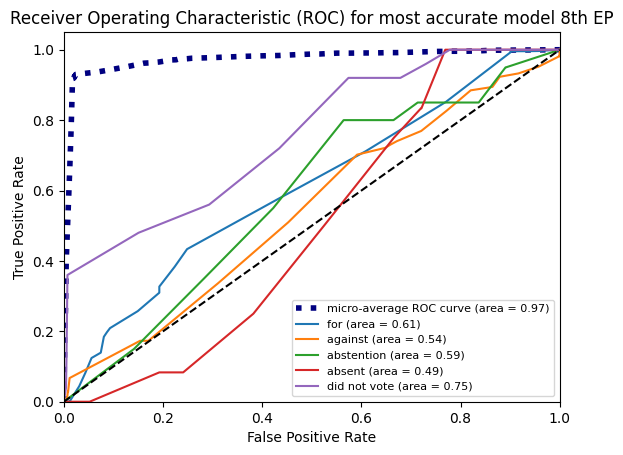

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention", "absent","did not vote"] # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for most accurate model 8th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [16]:
dummy = []
for i in range(0,20):
    dummy.append(str(i))


In [17]:
dummy[0]="Foreign & security policy/Budget/Civil liberties, justice & home affairs"
dummy[1]="Budgetary Control"
dummy[2]="Civil liberties, justice & home affairs"
dummy[6]="Foreign & security policy/Budget"
dummy[5]="Civil liberties, justice & home affairs"
dummy[8]= "International Trade"

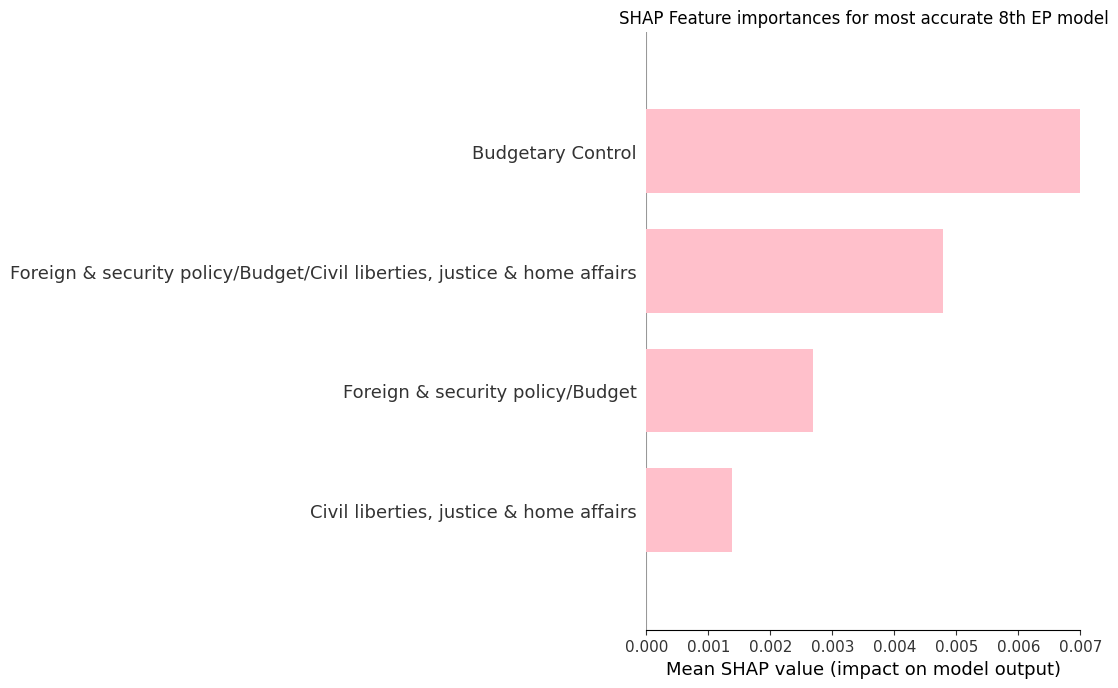

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=4,plot_type="bar", color="pink",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for most accurate 8th EP model")
plt.xlim([0,0.0070])
plt.gcf().set_size_inches(26,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()


# EP8 worst:
>124834

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []

# Loop through each MEP column and train a separate model for each MEP
    # Step 1: Prepare the data
X = lsa_comps8  # Input features (TF-IDF + truncated SVD features)
y = EP8["124834"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])
accuracy_score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)
print(np.mean(accuracy_score))


0.418570719102634


In [ ]:
np.unique(true_labels_array)

array([1, 2, 3, 4, 5, 6])

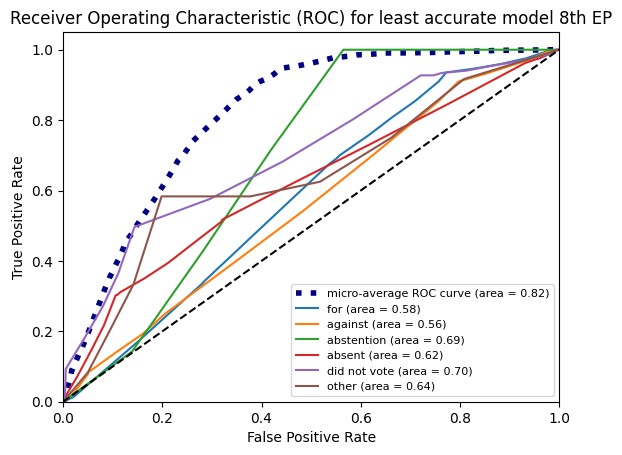

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
#aggregate_predictions = newpredlist
#aggregate_true_labels = newtruelist

# Define custom class names
class_names = [ "for", "against", "abstention", "absent","did not vote","other"]  # Add class names accordingly

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)
for i in range(num_classes):
  fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i], aggregate_predictions[:, i])
  #fpr[i], tpr[i], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)), aggregate_predictions)
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(), aggregate_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
color="navy", linestyle=":", linewidth=4,)
"""plt.plot(fpr["macro"], tpr["macro"],
label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
color="navy", linestyle=":", linewidth=4,)
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])"""
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for least accurate model 8th EP')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

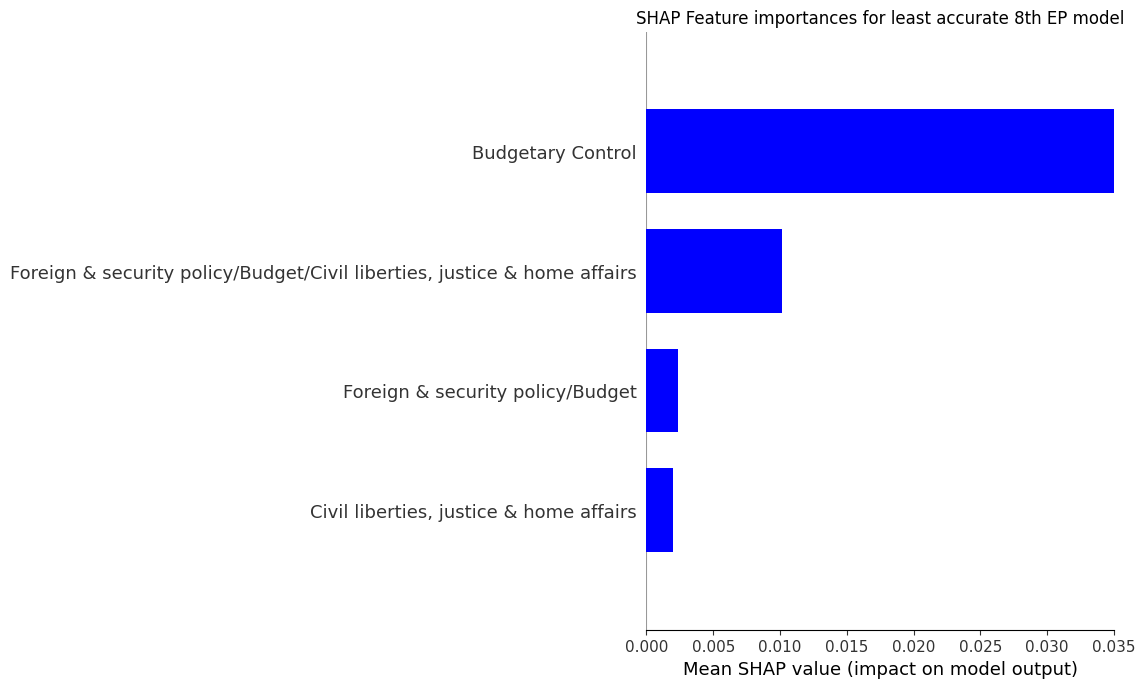

In [ ]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=4,plot_type="bar", color="blue",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for least accurate 8th EP model")
plt.xlim([0,0.035])
plt.gcf().set_size_inches(28,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()

# EP8 additional:
>4556

In [12]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 16.8 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    auc,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import shap
from sklearn.preprocessing import label_binarize

predictions_list = []

# Loop through each MEP column and train a separate model for each MEP
    # Step 1: Prepare the data
X = lsa_comps8  # Input features (TF-IDF + truncated SVD features)
y = EP8["4556"].values  # Target variable (voting behavior of the MEP)

    # Step 2: Split the data into training and testing sets
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Step 3: Choose and configure the model
model = Pipeline([
        ('scaler', StandardScaler()),  # You can apply additional preprocessing steps as needed
        ('classifier', RandomForestClassifier())  # Change the classifier as needed (e.g., DecisionTreeClassifier, RandomForestClassifier, SVC, MLPClassifier)
    ])
accuracy_score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            predictions = model.predict_proba(X_test)
            predictions_list.append((predictions, y_test))

max_dim = max(predictions.shape[1] for predictions, _ in predictions_list)
predictions_list = [(np.pad(predictions, [(0, 0), (0, max_dim - predictions.shape[1])]), true_labels) for predictions, true_labels in predictions_list]
predictions_array = np.concatenate([p[0] for p in predictions_list], axis=0)
true_labels_array = np.concatenate([p[1] for p in predictions_list], axis=0)
explainer = shap.TreeExplainer(model.named_steps['classifier'])
expected = explainer.expected_value
shap_values = explainer.shap_values(X_test)
importances = np.abs(shap_values).mean(axis=0)
print(np.mean(accuracy_score))


0.371683233385361


In [14]:
np.unique(true_labels_array)

array([1, 2, 3, 4, 5])

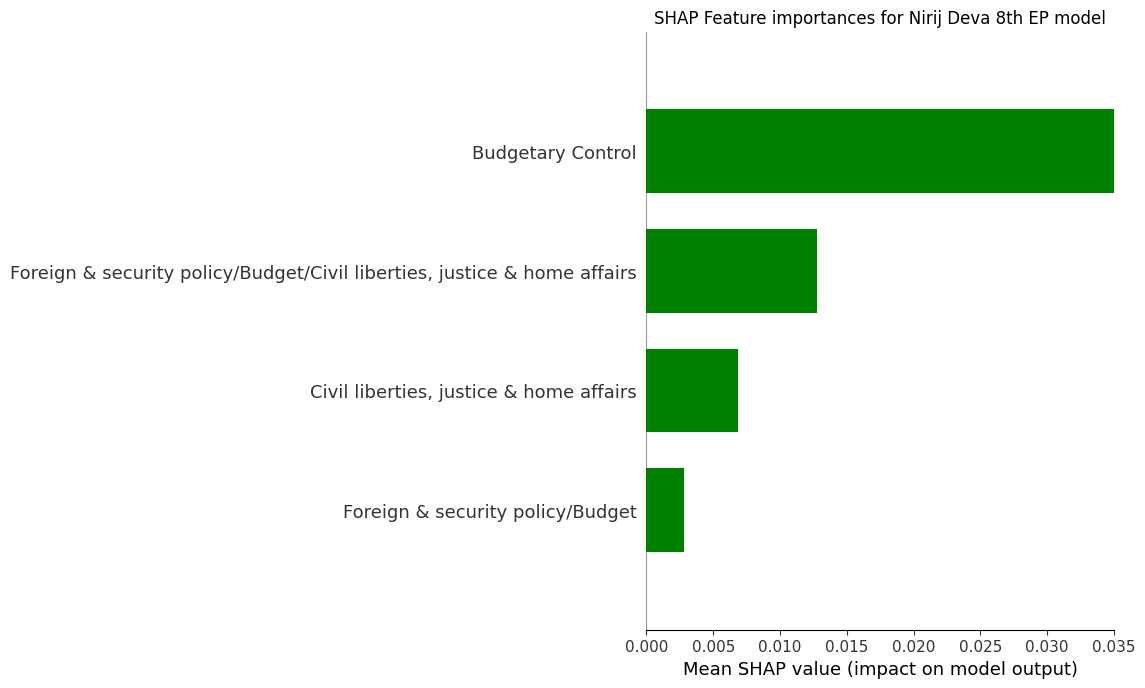

In [19]:
import shap
import matplotlib.pyplot as plt
fig = plt.figure()
shap.summary_plot(importances, X_test, max_display=4,plot_type="bar", color="green",feature_names=dummy,show=False)
plt.title("SHAP Feature importances for Nirij Deva 8th EP model")
plt.xlim([0,0.035])
plt.gcf().set_size_inches(28,8)
plt.xlabel("Mean SHAP value (impact on model output)")
plt.show()

AUPCR Curves

6thEP

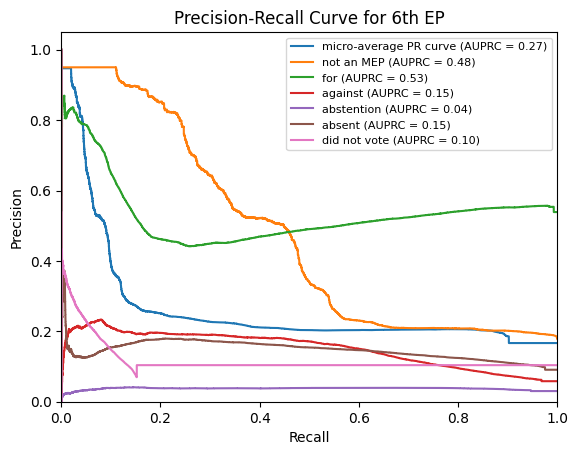

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
predictions_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predictions_6th.npy')
true_labels_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/truelabels_6th.npy')
# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
# aggregate_predictions = newpredlist
# aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent", "did not vote"]  # Add class names accordingly

# Compute precision-recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()

num_classes = len(class_names)
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i],
        aggregate_predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and AUPRC
precision["micro"], recall["micro"], _ = precision_recall_curve(
    label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(),
    aggregate_predictions.ravel())
average_precision["micro"] = auc(recall["micro"], precision["micro"])

# Plot AUPRC curve
plt.figure()
plt.step(recall["micro"], precision["micro"], where='post', label='micro-average PR curve (AUPRC = {0:0.2f})'.format(
    average_precision["micro"]))
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post',
             label='{0} (AUPRC = {1:0.2f})'.format(class_names[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for 6th EP')
plt.legend(loc="upper right", prop={'size': 8})
plt.show()


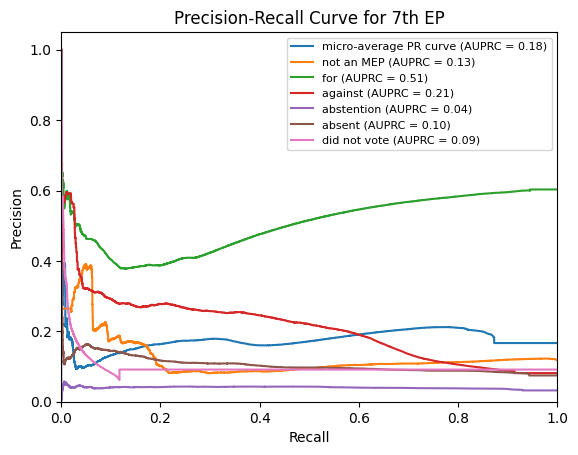

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
predictions_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predictions_7th.npy')
true_labels_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/truelabels_7th.npy')
# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
# aggregate_predictions = newpredlist
# aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent", "did not vote"]  # Add class names accordingly

# Compute precision-recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()

num_classes = len(class_names)
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i],
        aggregate_predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and AUPRC
precision["micro"], recall["micro"], _ = precision_recall_curve(
    label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(),
    aggregate_predictions.ravel())
average_precision["micro"] = auc(recall["micro"], precision["micro"])

# Plot AUPRC curve
plt.figure()
plt.step(recall["micro"], precision["micro"], where='post', label='micro-average PR curve (AUPRC = {0:0.2f})'.format(
    average_precision["micro"]))
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post',
             label='{0} (AUPRC = {1:0.2f})'.format(class_names[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for 7th EP')
plt.legend(loc="upper right", prop={'size': 8})
plt.show()

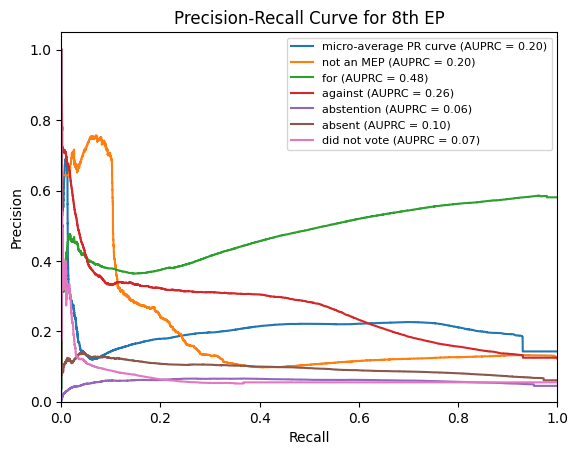

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
predictions_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/predictions_8th.npy')
true_labels_array = np.load('/content/drive/MyDrive/ Thesis 2023/Códigos finales (hopefully)/truelabels_8th.npy')
# Convert aggregate predictions and true labels to NumPy arrays
aggregate_predictions = predictions_array
aggregate_true_labels = true_labels_array
# aggregate_predictions = newpredlist
# aggregate_true_labels = newtruelist

# Define custom class names
class_names = ["not an MEP", "for", "against", "abstention", "absent", "did not vote"]  # Add class names accordingly

# Compute precision-recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()

num_classes = len(class_names)
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels))[:, i],
        aggregate_predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and AUPRC
precision["micro"], recall["micro"], _ = precision_recall_curve(
    label_binarize(aggregate_true_labels, classes=np.unique(aggregate_true_labels)).ravel(),
    aggregate_predictions.ravel())
average_precision["micro"] = auc(recall["micro"], precision["micro"])

# Plot AUPRC curve
plt.figure()
plt.step(recall["micro"], precision["micro"], where='post', label='micro-average PR curve (AUPRC = {0:0.2f})'.format(
    average_precision["micro"]))
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post',
             label='{0} (AUPRC = {1:0.2f})'.format(class_names[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for 8th EP')
plt.legend(loc="upper right", prop={'size': 8})
plt.show()